# CNN responses to new adaptive stimuli

In [36]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
import deepretina.visualizations as viz
from deepretina.preprocessing import datagen, loadexpt
from deepretina.utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Natural Scenes CNN Model and LN Model

In [4]:
architecture_filename = 'architecture.json'
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out
ln_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-11-08 04.41.18 LN/')
ln_weight_filename = 'epoch010_iter00750_weights.h5' # .468 cc on held-out

In [5]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

In [6]:
ln_architecture_data = open(ln_data_dir + architecture_filename, 'r')
ln_architecture_string = ln_architecture_data.read()
ln_model = model_from_json(ln_architecture_string)
ln_model.load_weights(ln_data_dir + ln_weight_filename)

# Low/High Contrast Stimuli  
In Fairhall et al 2001, they find fast adaptation of retinal responses to changing contrasts. The periods of high and low contrast they used were  
- 4 s  
- 10 s  
- 20 s  
- 40 s  

Our model however only has a memory of 400 ms. So we'll switch on the order of say 1 second.

In [13]:
period = 1 # 1 sec
sample_rate = 100 # 100 Hz
low_contrast = 0.1
high_contrast = 1.0

In [18]:
flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])

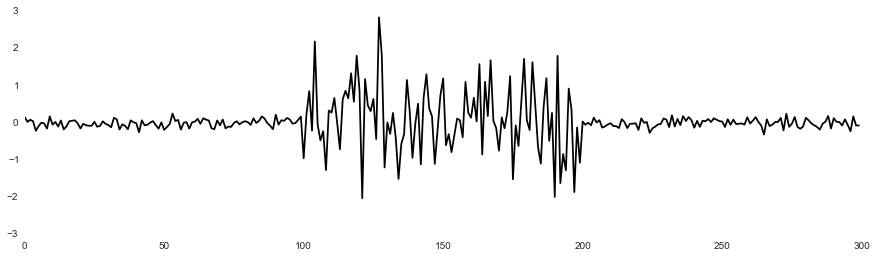

In [35]:
fig = plt.gcf()
fig.set_size_inches((15,4))
plt.plot(flicker_sequence, 'k')

### From flicker sequence to full field flicker movie

In [21]:
full_field_flicker = np.outer(flicker_sequence, np.ones((1,50,50)))
full_field_flicker = full_field_flicker.reshape((flicker_sequence.shape[0], 50, 50))

### Convert movie to 400ms long samples

In [37]:
full_field_movies = rolling_window(full_field_flicker, 40)

In [39]:
full_field_movies = np.rollaxis(full_field_movies, 2)
full_field_movies = np.rollaxis(full_field_movies, 3, 1)
full_field_movies.shape

(260, 40, 50, 50)

### Create function that generates a new sequence like this every time you want it

In [40]:
def get_full_field_flicker(period=1, low_contrast=0.1, high_contrast=1.0):
    sample_rate = 100
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    
    # Convert flicker sequence into full field movie
    full_field_flicker = np.outer(flicker_sequence, np.ones((1,50,50)))
    full_field_flicker = full_field_flicker.reshape((flicker_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
    full_field_movies = rolling_window(full_field_flicker, 40)
    full_field_movies = np.rollaxis(full_field_movies, 2)
    full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    return full_field_movies

## Get Responses to Low/High Contrast Stimulus

In [52]:
ntrials = 2000
period = 1
sample_rate = 100
batch_size = 26
nsamples = 3*period*sample_rate - 40
assert nsamples % batch_size == 0, 'nsamples must be divisible by batch_size'
cnn_responses = np.zeros((ntrials, nsamples))
ln_responses = np.zeros((ntrials, nsamples))
for n in range(ntrials):
    if n % 50 == 0:
        print 'Starting %d trial out of %d.' %(n,ntrials)
    stimulus = get_full_field_flicker()
    for batch in range(nsamples/batch_size):
        cnn_responses[n, batch*batch_size:(batch+1)*batch_size] = \
            naturalscenes_model.predict(stimulus[batch*batch_size:(batch+1)*batch_size])[:,0]
        ln_responses[n, batch*batch_size:(batch+1)*batch_size] = \
            ln_model.predict(stimulus[batch*batch_size:(batch+1)*batch_size])[:,0]

Starting 0 trial out of 2000.
Starting 50 trial out of 2000.
Starting 100 trial out of 2000.
Starting 150 trial out of 2000.
Starting 200 trial out of 2000.
Starting 250 trial out of 2000.
Starting 300 trial out of 2000.
Starting 350 trial out of 2000.
Starting 400 trial out of 2000.
Starting 450 trial out of 2000.
Starting 500 trial out of 2000.
Starting 550 trial out of 2000.
Starting 600 trial out of 2000.
Starting 650 trial out of 2000.
Starting 700 trial out of 2000.
Starting 750 trial out of 2000.
Starting 800 trial out of 2000.
Starting 850 trial out of 2000.
Starting 900 trial out of 2000.
Starting 950 trial out of 2000.
Starting 1000 trial out of 2000.
Starting 1050 trial out of 2000.
Starting 1100 trial out of 2000.
Starting 1150 trial out of 2000.
Starting 1200 trial out of 2000.
Starting 1250 trial out of 2000.
Starting 1300 trial out of 2000.
Starting 1350 trial out of 2000.
Starting 1400 trial out of 2000.
Starting 1450 trial out of 2000.
Starting 1500 trial out of 2000.


## Average responses to get adaptation expectations

In [53]:
average_cnn_response = np.mean(cnn_responses, 0)
average_ln_response = np.mean(ln_responses, 0)

#### For plotting purposes, get multiple flicker sequences

In [74]:
flicker_sequences = []
for i in range(100):
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    flicker_sequences.append(flicker_sequence)

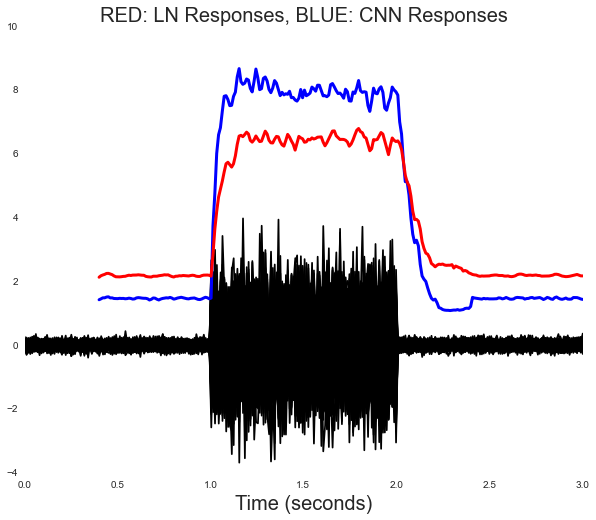

In [75]:
# Plot multiple flicker sequences
for flicker in flicker_sequences:
    plt.plot(np.linspace(0,3,300), flicker, 'k')

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,3,260), average_cnn_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,3,260), average_ln_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Contrast Adaptation.png', dpi=500)

# Flash Stimuli  
Test response to two 10 ms flashes at different spacings

In [76]:
# Total duration of 1 sec
nsamples = 1*100
flash_sequence = np.zeros((nsamples,))

# Make two flashes
initial_flash = 45 # 450 ms
flash_latency = 10 # 100 ms
flash_sequence[initial_flash] = 1
flash_sequence[initial_flash+flash_latency] = 1

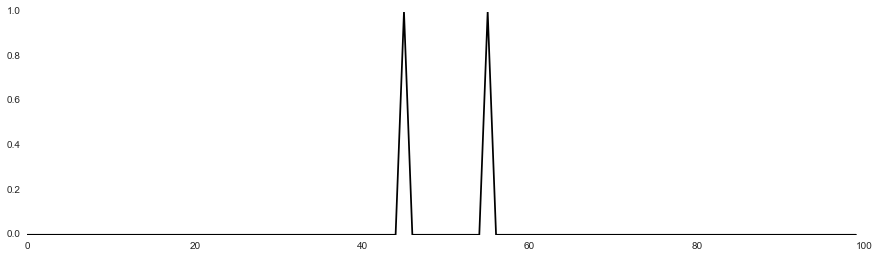

In [79]:
fig = plt.gcf()
fig.set_size_inches((15,4))
plt.plot(flash_sequence, 'k')

In [91]:
def get_flash_sequence(initial_flash=45, latency=10, nsamples=100):
    flash_sequence = np.zeros((nsamples,))

    # Make two flashes
    flash_sequence[initial_flash] = 1
    flash_sequence[initial_flash+latency] = 1
    return flash_sequence

In [92]:
def get_full_field_flashes(initial_flash=45, latency=10, nsamples=100):
    flash_sequence = get_flash_sequence(initial_flash=initial_flash, latency=latency, nsamples=nsamples)
    
    # Convert flash sequence into full field movie
    full_field_flash = np.outer(flash_sequence, np.ones((1,50,50)))
    full_field_flash = full_field_flash.reshape((flash_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
    full_field_movies = rolling_window(full_field_flash, 40)
    full_field_movies = np.rollaxis(full_field_movies, 2)
    full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    return full_field_movies

# Short latency to long latency

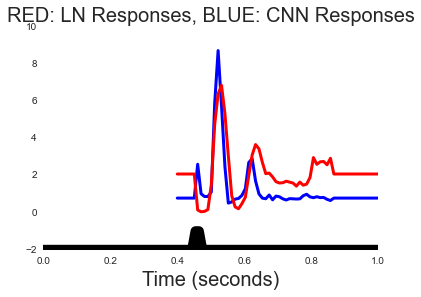

In [155]:
flash_stimulus = get_full_field_flashes(latency=0)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=1)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

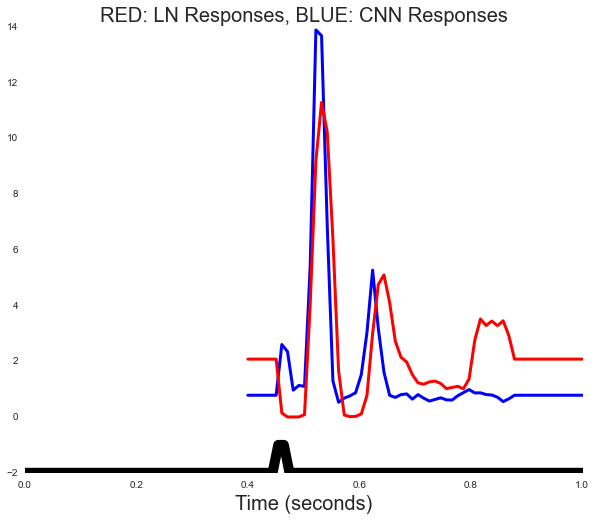

In [93]:
flash_stimulus = get_full_field_flashes(latency=1)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=1)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

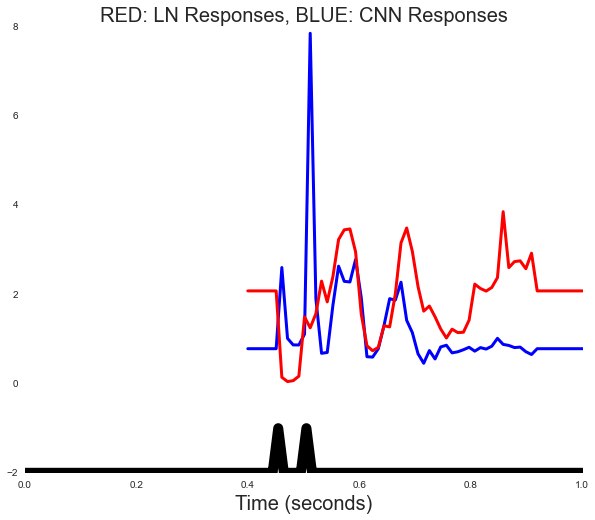

In [94]:
flash_latency = 5
flash_stimulus = get_full_field_flashes(latency=flash_latency)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=flash_latency)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

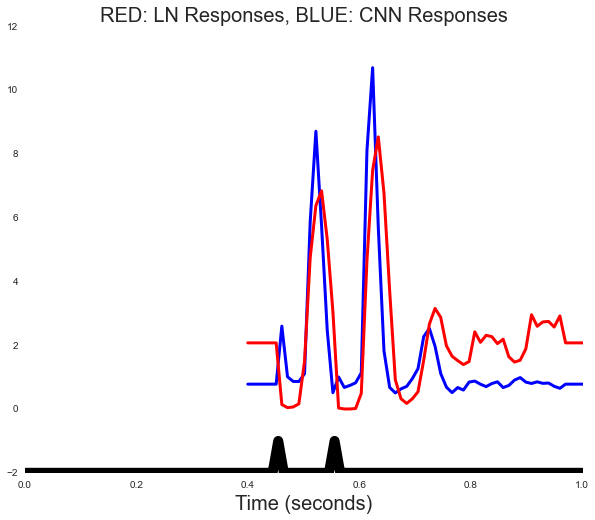

In [95]:
flash_latency = 10
flash_stimulus = get_full_field_flashes(latency=flash_latency)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=flash_latency)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

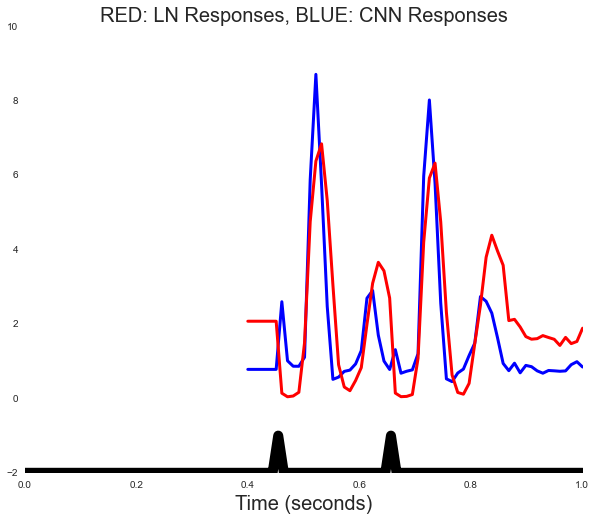

In [96]:
flash_latency = 20
flash_stimulus = get_full_field_flashes(latency=flash_latency)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=flash_latency)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

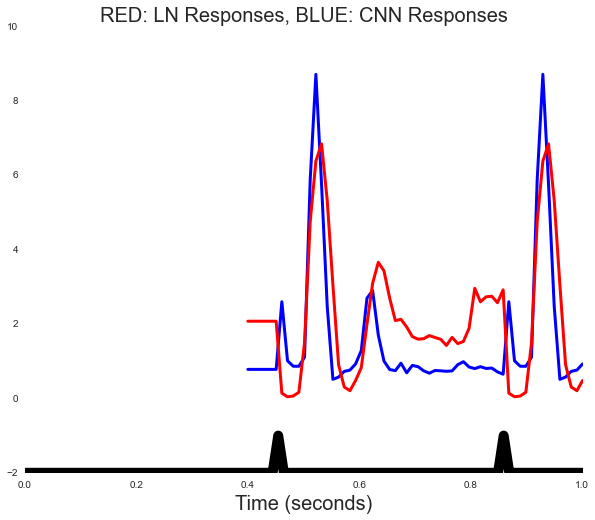

In [97]:
flash_latency = 40
flash_stimulus = get_full_field_flashes(latency=flash_latency)
ln_flash_response = ln_model.predict(flash_stimulus)
cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

# Plot flash sequence
flash_sequence = get_flash_sequence(latency=flash_latency)
plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

# Plot average CNN and LN responses
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
plt.savefig('Flash Response.png', dpi=500)

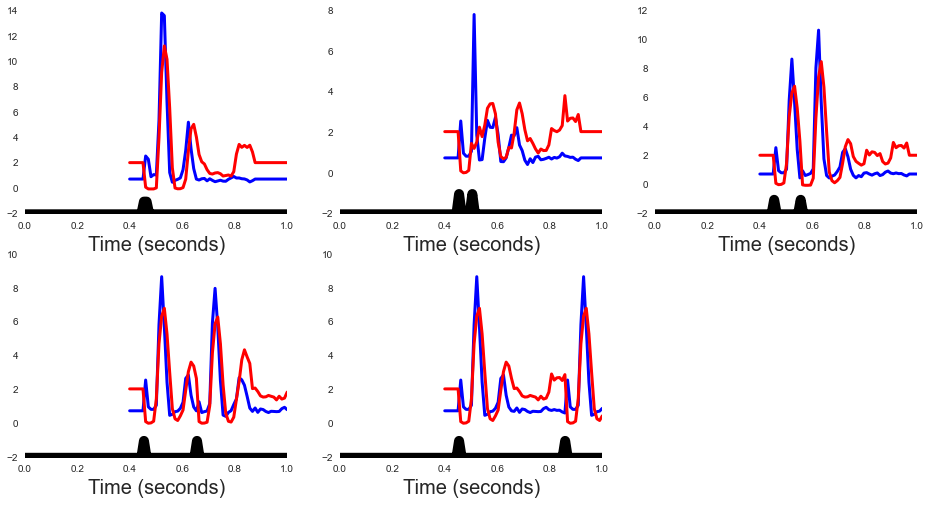

In [102]:
fig = plt.gcf()
fig.set_size_inches((16,8))
latencies = [1, 5, 10, 20, 40]
num_cols = 3
num_rows = 2
plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = x + num_cols*y + 1
        if plt_idx < num_cols*num_rows:
            plt.subplot(2,3,plt_idx)
            flash_latency = latencies[plt_idx-1]
            flash_stimulus = get_full_field_flashes(latency=flash_latency)
            ln_flash_response = ln_model.predict(flash_stimulus)
            cnn_flash_response = naturalscenes_model.predict(flash_stimulus)

            # Plot flash sequence
            flash_sequence = get_flash_sequence(latency=flash_latency)
            plt.plot(np.linspace(0,nsamples/100,nsamples), flash_sequence - 2, 'k', linewidth=10)

            # Plot average CNN and LN responses
            plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), cnn_flash_response, 'b', linewidth=3)
            plt.plot(np.linspace(0.4,nsamples/100,nsamples-40), ln_flash_response, 'r', linewidth=3)
            plt.xlabel('Time (seconds)', fontsize=20)
            #plt.title('RED: LN Responses, BLUE: CNN Responses', fontsize=20)
        
        

In [105]:
tmp = get_full_field_flashes(latency=10)

In [106]:
tmp.shape

(60, 40, 50, 50)

#### These flashes look very strange; what is the STA of the LN model?

In [163]:
ln_weights = h5py.File(ln_data_dir + ln_weight_filename, 'r')
list(ln_weights)

[u'layer_0', u'layer_1']

In [173]:
ln_1st_layer_output = theano.function([ln_model.layers[0].input], 
                                              ln_model.layers[1].get_output(train=False))

In [175]:
nsamples = 1000
batch_size = 50
ln_sta = np.zeros((40,50,50), dtype='float32')
for iteration in range(nsamples):
    sample = np.random.randn(batch_size, 40, 50, 50).astype('float32')
    ln_response = ln_1st_layer_output(sample) # batch_size x n_interunits
    
    ln_sta_subset = np.tensordot(ln_response.T, sample, axes=1)
    ln_sta += ln_sta_subset[0]

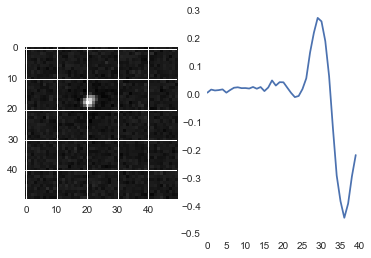

In [177]:
space, time = ft.decompose(ln_sta)
plt.subplot(1,2,1)
plt.imshow(space)
plt.subplot(1,2,2)
plt.plot(time)

In [178]:
impulse_response = []
for i in range(40):
    impulse = np.zeros((1,40,50,50))
    impulse[0,i,:,:] = 1
    impulse_response.extend(ln_model.predict(impulse))

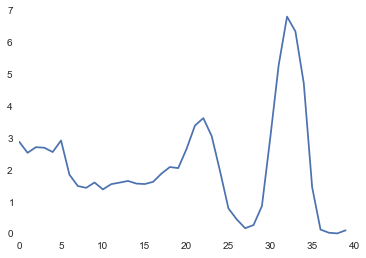

In [179]:
plt.plot(impulse_response)

# Reversing Gratings

In [160]:
grating_width = 1
grating_frame = -1*np.ones((50,50))
grating_frame[:,::2*grating_width] = 1

<matplotlib.colorbar.Colorbar instance at 0x14db3fc68>

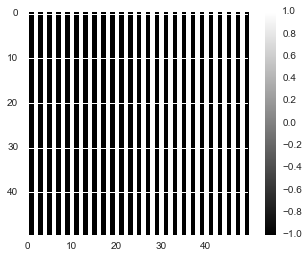

In [161]:
plt.imshow(grating_frame)
plt.colorbar()

In [ ]:
switch_every = 10
movie_duration = 100 # 1 s at 100 Hz
grating_movie = np.zeros((movie_duration, 50, 50))
polarity_count = 0
for frame in range(movie_duration):
    polarity_count += 1
    if int(polarity_count/switch_every) % 2 == 0:
        grating_movie[frame] = grating_frame
    else:
        grating_movie[frame] = -1 * grating_frame